### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import log_loss, roc_curve, auc, roc_auc_score

### Load data set

In [2]:
data = pd.read_csv('../data/small_training_cleansed.zip', compression='zip')

Function that select features which have lowest correlation between each other

In [3]:
def get_low_corr_df(d):
    # Remove class2 because we dont want to drop features that correlate with class2
    d = d.drop('class2', axis=1)

    # Create correlation matrix
    corr_matrix = d.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find features with correlation greater than 0.35
    to_drop = [column for column in upper.columns if any(upper[column] > 0.35)]

    # Remove features that have great correlation
    d = d.drop(d[to_drop], axis=1)

    # Add class2 back to the dataframe
    d['class2'] = data['class2']

    return d

Create new dataframe that has column whith low correlation

In [4]:
data_low_corr = get_low_corr_df(data)

Let's how the data looks.

In [5]:
data.describe()

,CO2504.mean,Glob.mean,H2O672.mean,NET.mean,NO672.mean,NOx672.mean,O3672.mean,Pamb0.mean,PAR.mean,PTG.mean,RGlob.mean,RHIRGA672.mean,RPAR.mean,SO2168.mean,SWS.mean,T672.mean,UV_A.mean,CS.mean,class2
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000
mean,380.913345,193.287920,7.160940,122.390867,0.055901,1.266881,34.353575,991.354278,382.301574,-0.000372,27.427025,69.686362,18.259929,0.190684,914.221105,6.311782,10.961236,0.002974,0.500000
std,10.900973,126.058537,3.798081,86.464582,0.049923,0.983461,9.079498,9.686386,247.429828,0.003309,16.608088,20.185316,11.011583,0.177113,13.483655,9.680534,6.633754,0.001941,0.500547
min,356.841429,3.719434,1.000147,-47.799712,-0.012456,0.079111,10.406360,967.083487,7.530252,-0.007723,-1.122083,26.695342,0.000000,-0.020408,886.641871,-23.288234,0.295780,0.000227,0.000000
25%,372.921420,71.773357,4.004424,47.394350,0.018626,0.483321,28.521357,985.171848,142.709806,-0.002661,12.388924,52.135258,9.826067,0.056376,908.504834,-1.298557,4.937496,0.001500,0.000000
50%,380.113959,197.939217,6.279441,124.559808,0.039294,1.004342,34.320171,991.517281,395.843812,0.000000,28.415197,69.926589,17.740020,0.128417,918.368227,7.320084,11.702413,0.002475,0.500000
75%,388.296775,304.162015,9.949462,194.753205,0.076252,1.714546,40.598021,997.230756,595.037771,0.001170,41.957688,88.316804,24.608422,0.256596,923.080143,13.964999,16.727710,0.004176,1.000000
max,411.348676,449.450545,18.864270,296.188303,0.162691,3.561385,58.713018,1015.319117,830.082577,0.006916,83.859893,104.185588,46.781954,0.556927,934.925926,25.684185,22.560576,0.008191,1.000000


In [6]:
data_low_corr.describe()

,CO2504.mean,Pamb0.mean,PTG.mean,class2
count,458.000000,458.000000,458.000000,458.000000
mean,380.913345,991.354278,-0.000372,0.500000
std,10.900973,9.686386,0.003309,0.500547
min,356.841429,967.083487,-0.007723,0.000000
25%,372.921420,985.171848,-0.002661,0.000000
50%,380.113959,991.517281,0.000000,0.500000
75%,388.296775,997.230756,0.001170,1.000000
max,411.348676,1015.319117,0.006916,1.000000


In [7]:
data_dict = {'all': data,
             'low corr': data_low_corr}

# Plot the correlation matrices of the two dataframes.

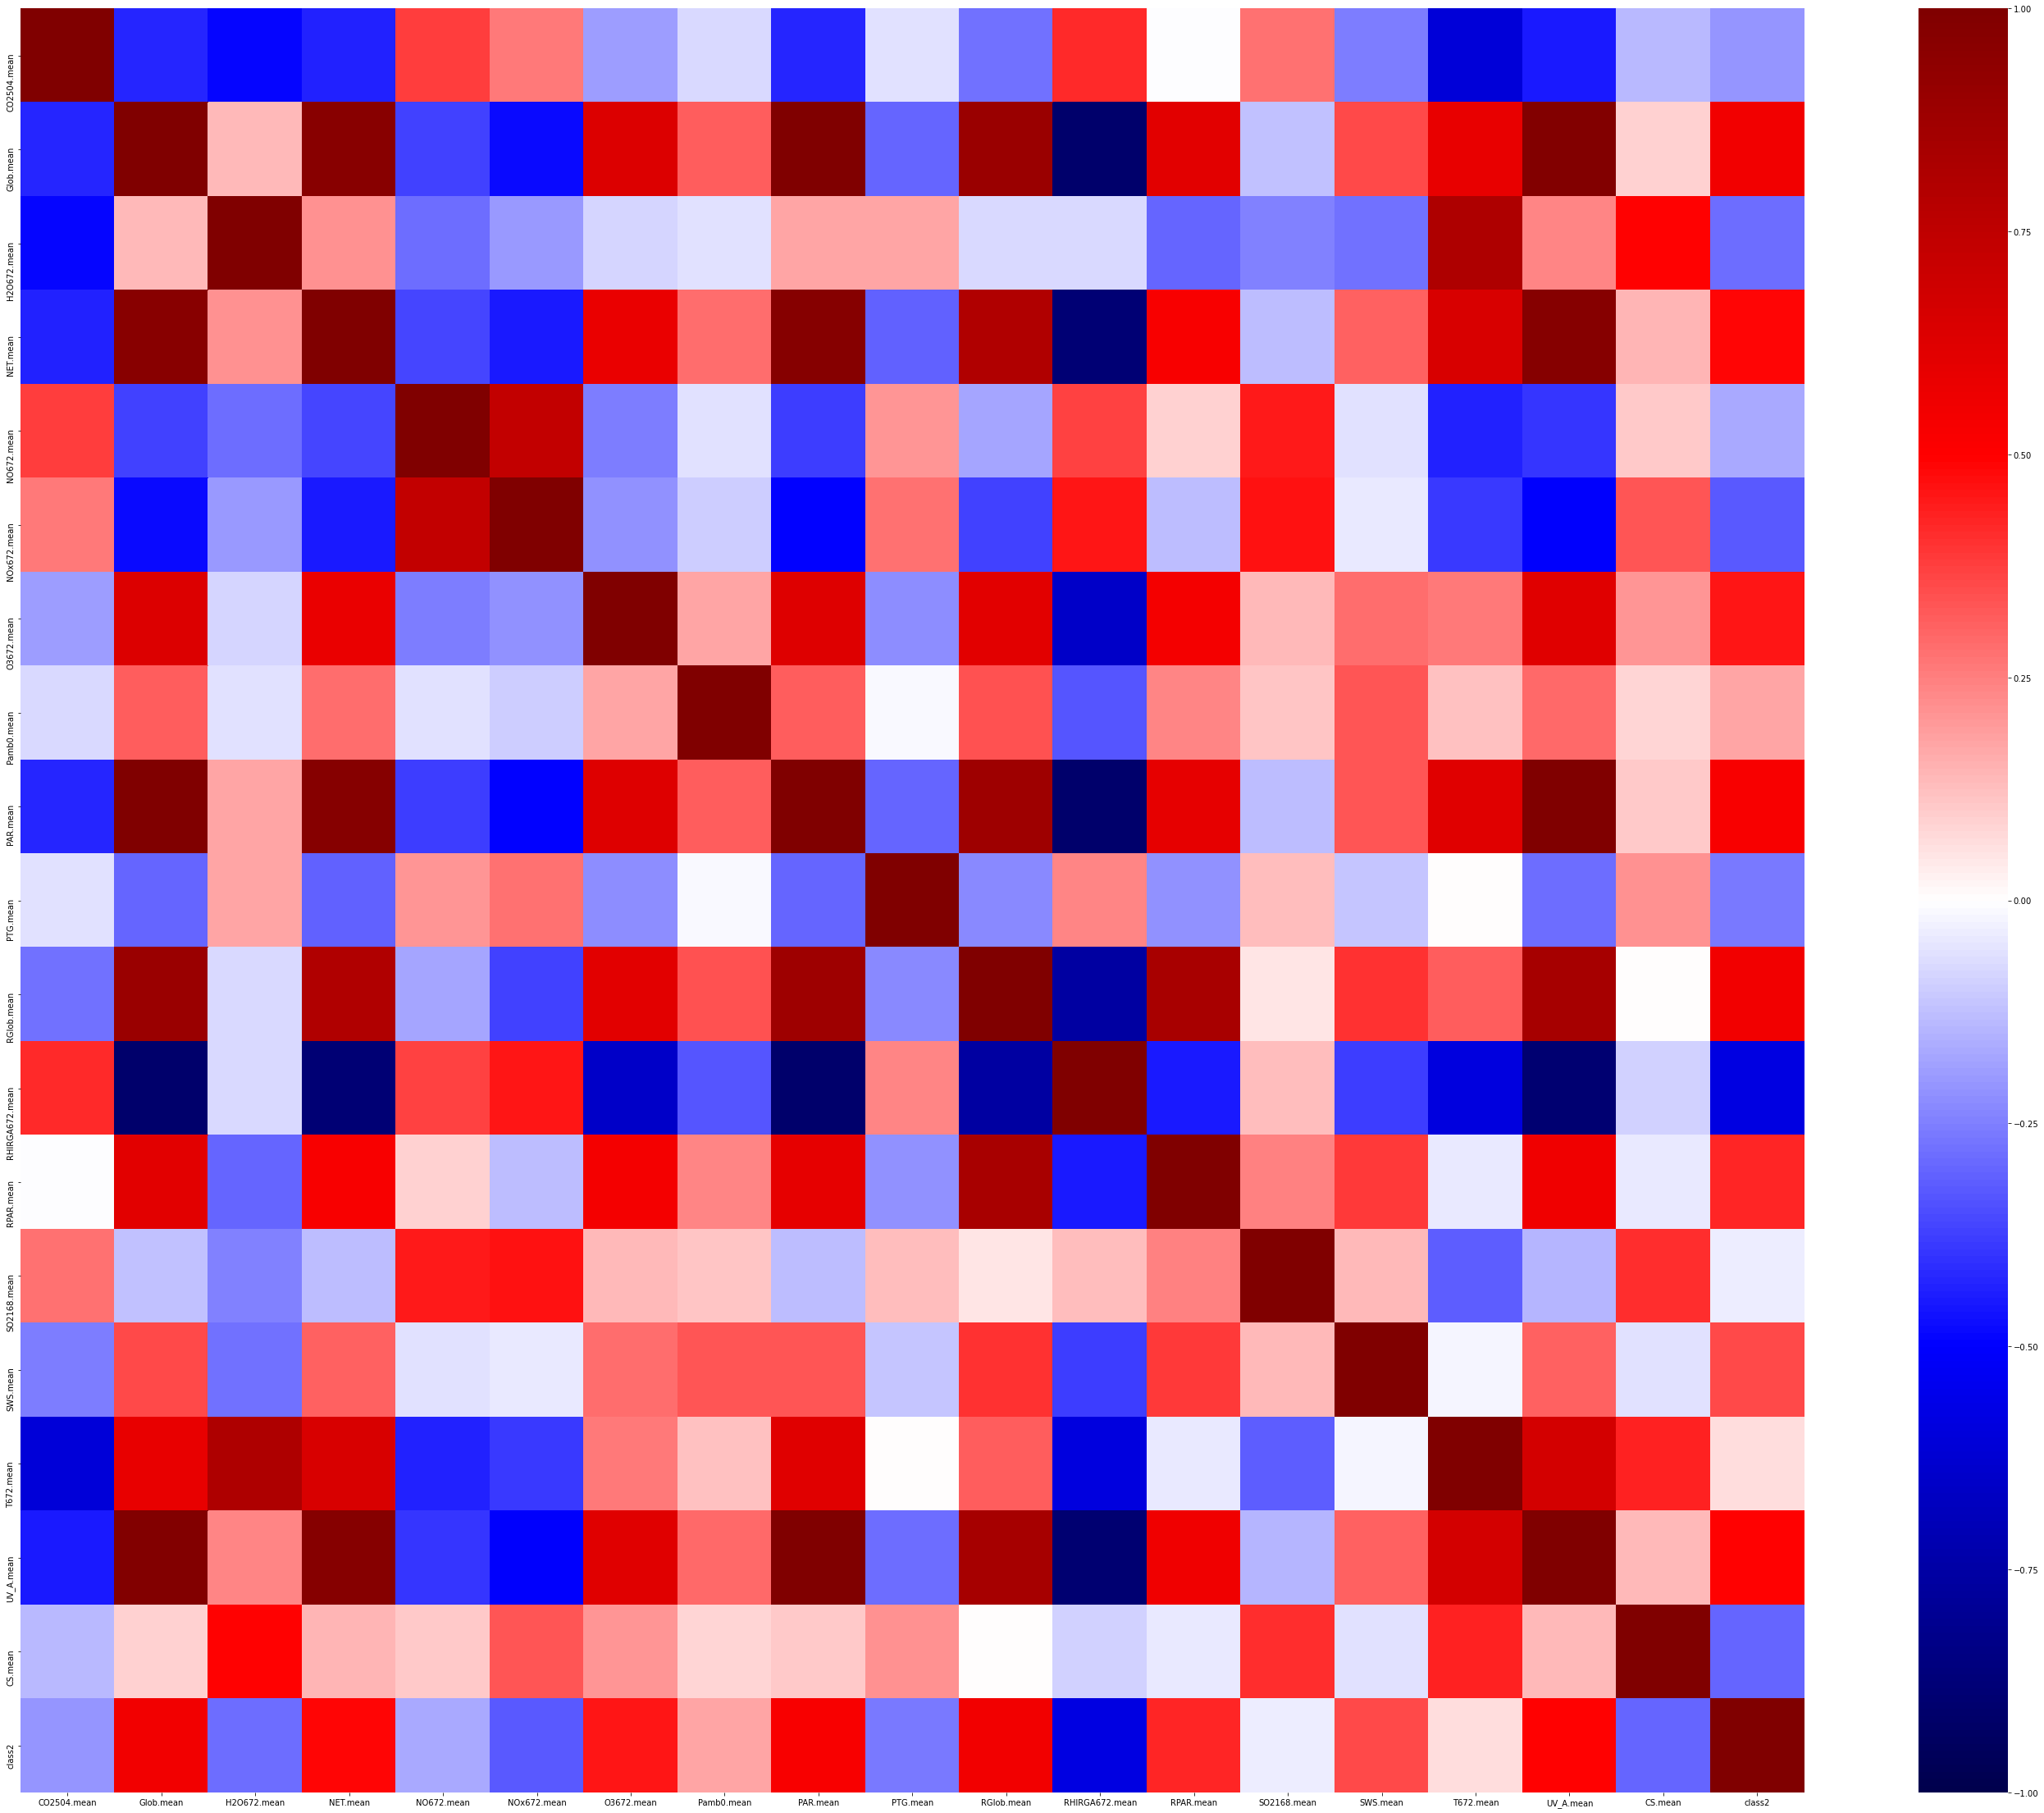

In [8]:
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(50, 40))
ax = sns.heatmap(corr_matrix, cmap='seismic', vmin=-1, vmax=1, square=True)

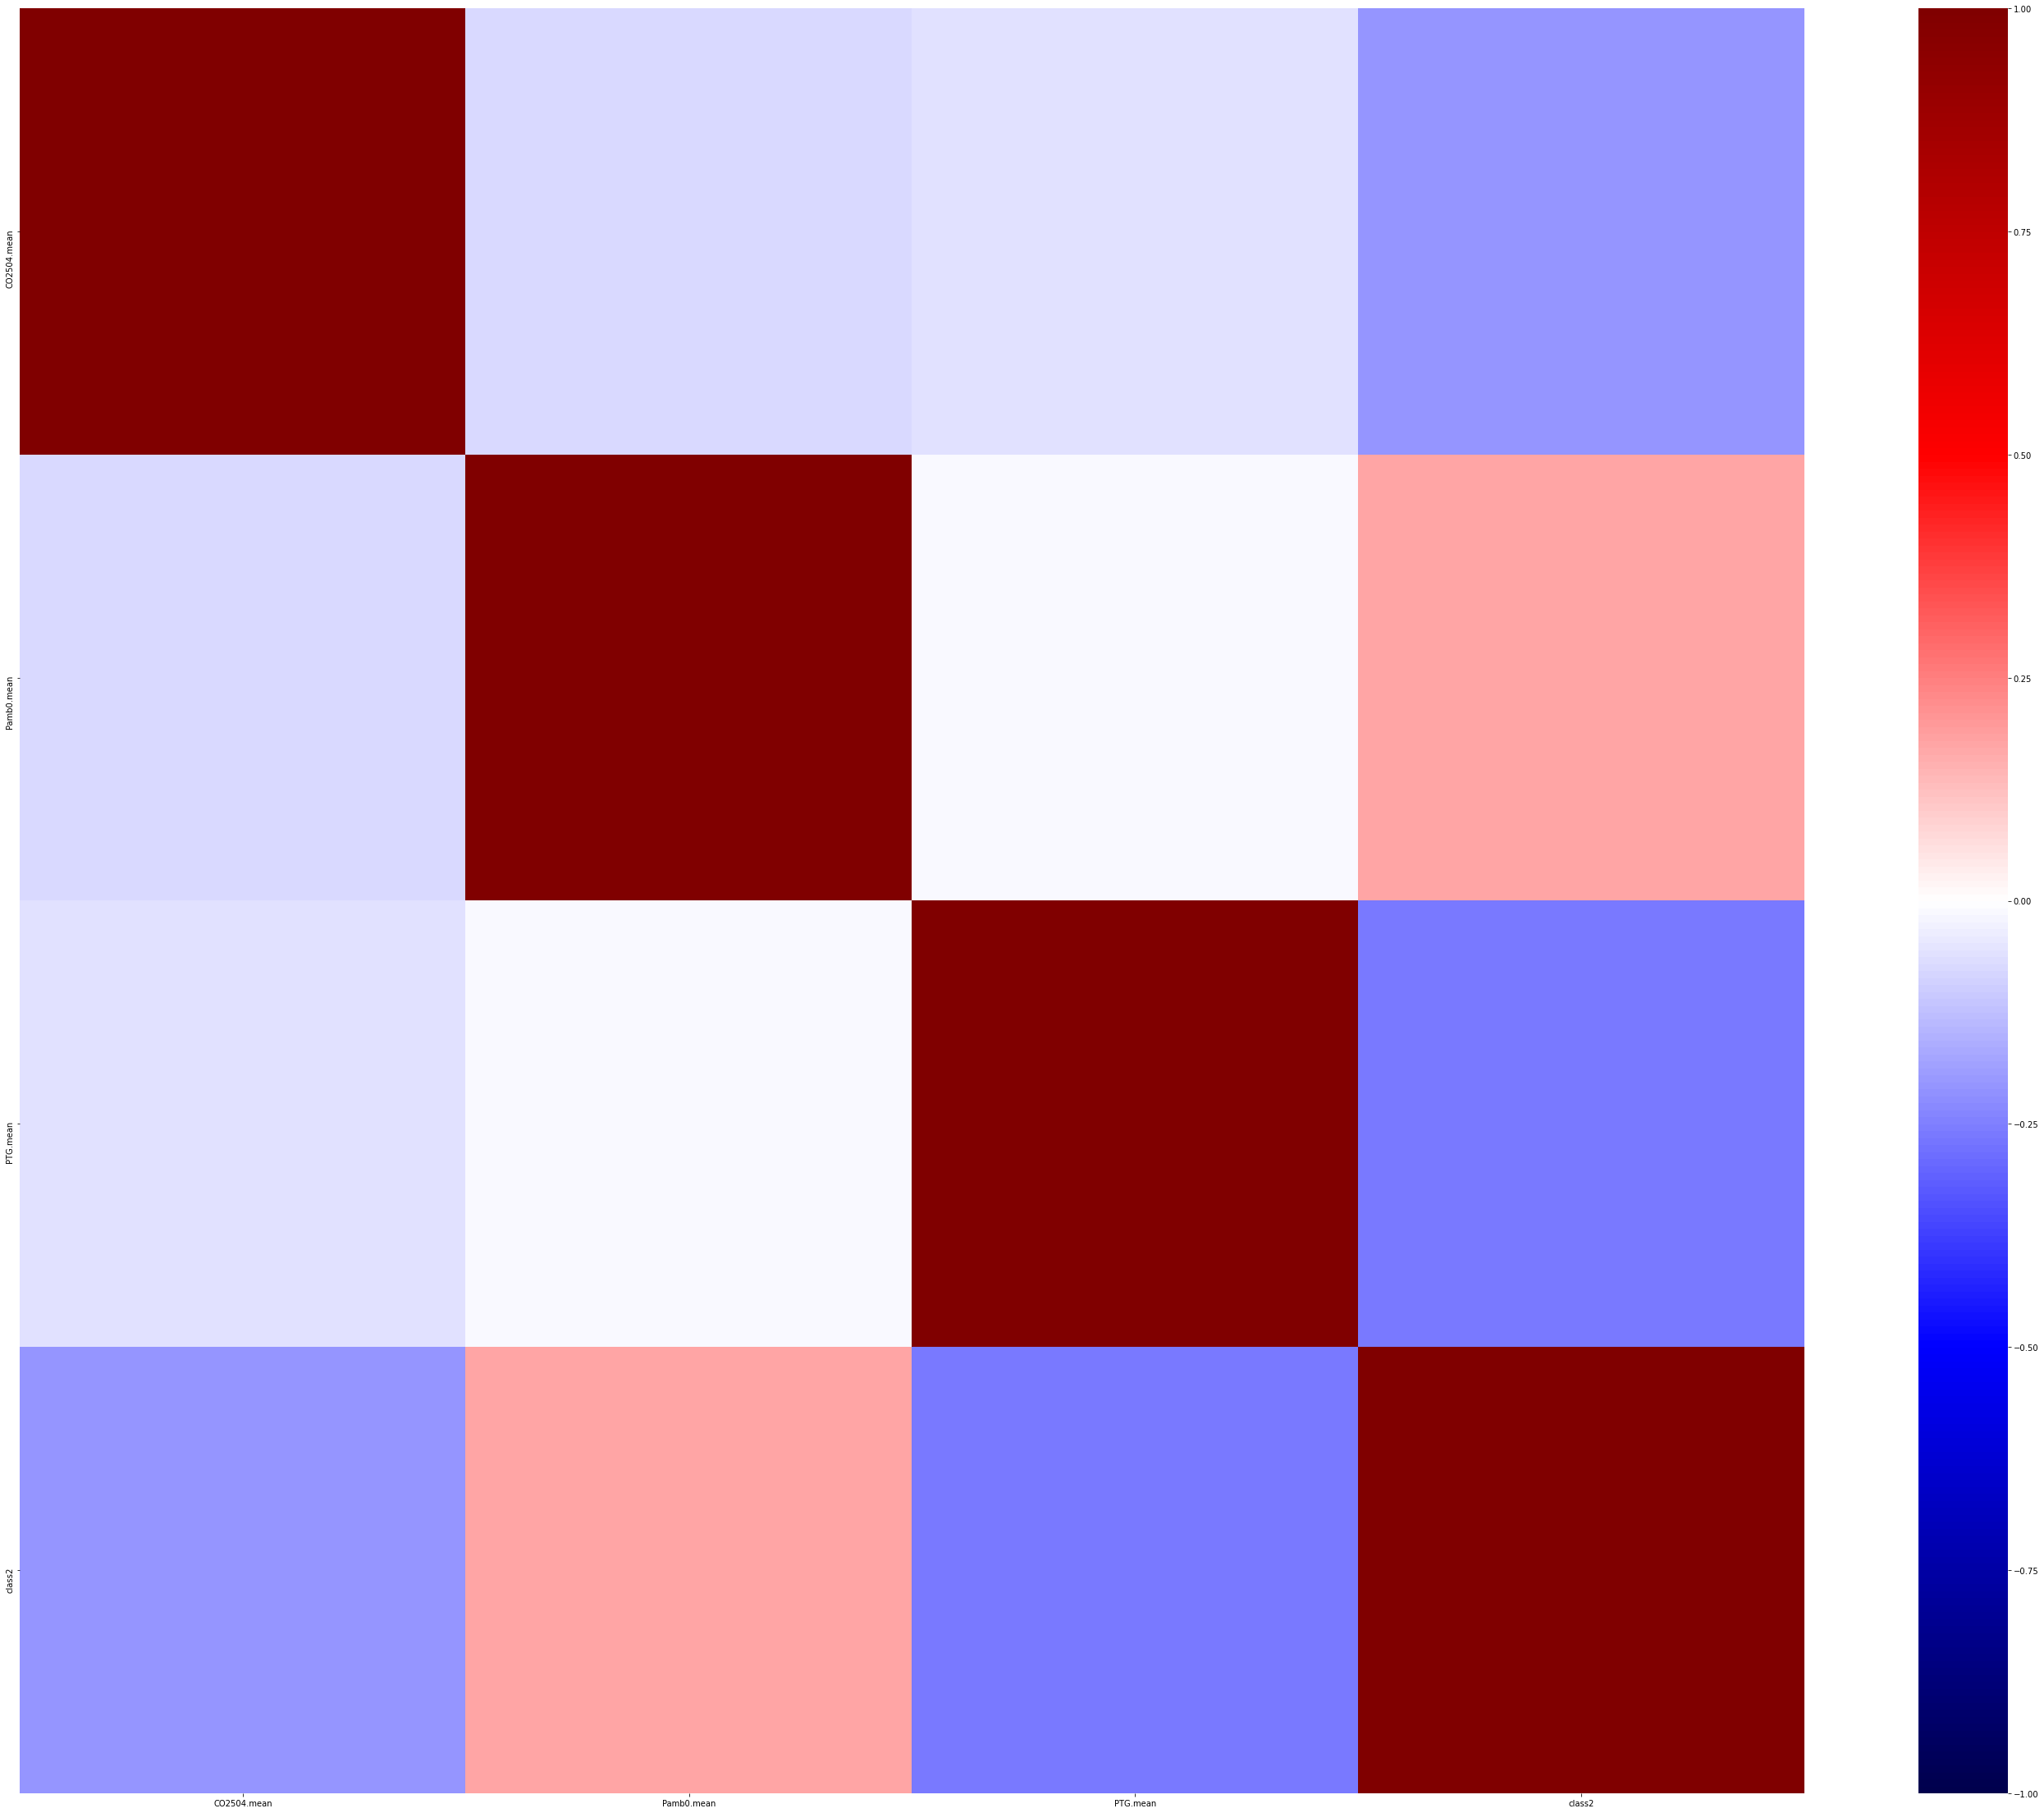

In [9]:
corr_matrix = data_low_corr.corr()
f, ax = plt.subplots(figsize=(50, 40))
ax = sns.heatmap(corr_matrix, cmap='seismic', vmin=-1, vmax=1, square=True)

In [12]:
# Naive bayes model
gnb = GaussianNB(priors=[0.6, 0.4])

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(data.drop('class2', axis=1).values, data['class2'].values, test_size=0.3, random_state=0)
X_train_lowcorr, X_test_lowcorr, y_train_lowcorr, y_test_lowcorr = train_test_split(data_low_corr.drop('class2', axis=1).values, data_low_corr['class2'].values, test_size=0.3, random_state=0)

# Predict
y_pred = gnb.fit(X_train, y_train).predict(X_test)
y_pred_lowcorr = gnb.fit(X_train_lowcorr, y_train_lowcorr).predict(X_test_lowcorr)

# Predictable classes
print(gnb.classes_)


[0 1]


# Confusion Matrix and ROC curve for the full data and low correlation data

<Figure size 432x288 with 0 Axes>

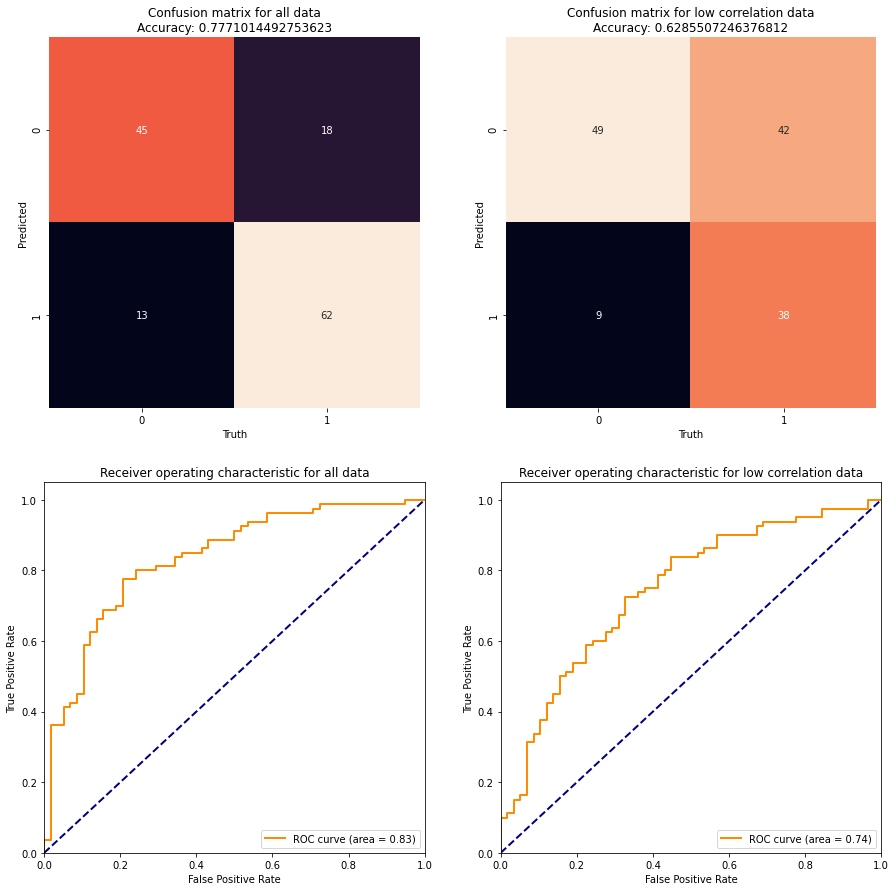

In [13]:
plt.clf()

figure, axes = plt.subplots(2,2)

figure.set_size_inches(15, 15)

mat = confusion_matrix(y_pred, y_test)
names = np.unique(y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names, yticklabels=names, ax=axes[0, 0])
axes[0, 0].set(xlabel='Truth', ylabel='Predicted', title='Confusion matrix for all data\nAccuracy: {}'.format(np.mean(cross_val_score(gnb, data.drop('class2', axis=1).values, data['class2'].values, cv=10)))) #np.mean(cross_val_score(gnb, data.drop('class2', axis=1).values, data['class2'].values, cv=10))   accuracy_score(y_test, y_pred)

mat_lowcorr = confusion_matrix(y_pred_lowcorr, y_test_lowcorr)
names_lowcorr = np.unique(y_pred_lowcorr)
sns.heatmap(mat_lowcorr, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=names_lowcorr, yticklabels=names_lowcorr, ax=axes[0, 1])
axes[0, 1].set(xlabel='Truth', ylabel='Predicted', title='Confusion matrix for low correlation data\nAccuracy: {}'.format(np.mean(cross_val_score(gnb, data_low_corr.drop('class2', axis=1).values, data_low_corr['class2'].values, cv=10)))) # accuracy_score(y_test_lowcorr, y_pred_lowcorr)

y_pred_prob = gnb.fit(X_train, y_train).predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
lw = 2
axes[1, 0].plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc
)
axes[1, 0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
axes[1, 0].set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', title='Receiver operating characteristic for all data')
axes[1, 0].legend(loc='lower right')

y_pred_prob_lowcorr = gnb.fit(X_train_lowcorr, y_train_lowcorr).predict_proba(X_test_lowcorr)[:, 1]
fpr_lowcorr, tpr_lowcorr, _ = roc_curve(y_test_lowcorr, y_pred_prob_lowcorr)
roc_auc_lowcorr = roc_auc_score(y_test_lowcorr, y_pred_prob_lowcorr)
lw = 2
axes[1, 1].plot(
    fpr_lowcorr,
    tpr_lowcorr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_lowcorr
)
axes[1, 1].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
axes[1, 1].set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', title='Receiver operating characteristic for low correlation data')
axes[1, 1].legend(loc='lower right')

# Feature selection.

Select $k$ best features for both of the dataframes. Here $k$ is 1 - # of features.

We will use the data with all features here because the low correlation data doesnt have good results on this classification task.

In [15]:
k_best = {}

data_to_use = data

predictors = data_to_use.drop('class2', axis=1).values
predictable = data_to_use['class2'].values

col_n = predictors.shape[1] + 1

for i in range(1, col_n):
    i_best = SelectKBest(f_classif, k=i)
    k_best[str(i)] = i_best

Calculate accuracy and perplexity for each kBest feature

In [16]:
# Using all of the variables except class2 (predictable variable) and class4
def get_xy(df):
    if ('class4' in df.columns.values):
        df = df.drop('class4', axis=1)
    X = df.drop('class2', axis=1).values
    y = data['class2'].ravel()
    return [X, y]

def perplexity(y_true, y_pred_proba):
    # return np.exp(-np.mean(np.log((y_true == 1) * y_pred_proba + (y_true == 0) * (1 - y_pred_proba))))
    return np.exp(np.mean(log_loss(y_true, y_pred_proba)))

use_k_best = True

dict_to_use = k_best if use_k_best else data_dict # data_dict k_best

eventPrios = []
pred = np.zeros(shape=(9, len(dict_to_use)))
perp = np.zeros(shape=(9, len(dict_to_use)))

for i in range(1, 10):
    prio = i/10
    eventPrios.append(prio)
    gnb = GaussianNB(priors=[prio, (1-prio)])

    temp_pred = []
    temp_perp = []
    for value in dict_to_use.values():
        if use_k_best:
            x_values = value.fit_transform(predictors, predictable)
            X_train, X_test, y_train, y_test = train_test_split(x_values, predictable, test_size=0.3, random_state=0)
        else:
            xy = get_xy(value)
            X_train, X_test, y_train, y_test = train_test_split(xy[0], xy[1], test_size=0.3, random_state=0)
        
        y_pred = gnb.fit(X_train, y_train).predict(X_test)
        # temp_pred.append(accuracy_score(y_test, y_pred))
        temp_pred.append(np.mean(cross_val_score(gnb, x_values, predictable, cv=10)))

        y_pred_prob = gnb.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        temp_perp.append(perplexity(y_test, y_pred_prob))

    pred[i-1] = np.array(temp_pred)
    perp[i-1] = np.array(temp_perp)
    
    

Show result for each k amount of features selected

In [17]:
def get_df_data():
    d = {}
    for i, key in enumerate(dict_to_use):
        column_name = 'k = {}'.format(key)
        d[column_name] = pred[:, i]
    return d

resultDf = pd.DataFrame(index=eventPrios, data=get_df_data())
resultDf

,k = 1,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,k = 9,k = 10,k = 11,k = 12,k = 13,k = 14,k = 15,k = 16,k = 17,k = 18
0.1,0.648406,0.744396,0.766329,0.757488,0.753043,0.753043,0.761739,0.761739,0.759662,0.757536,0.757536,0.772802,0.772802,0.777198,0.777198,0.770676,0.772850,0.768502
0.2,0.718164,0.761884,0.761836,0.764010,0.761739,0.761739,0.766135,0.761787,0.766232,0.768454,0.768454,0.777150,0.781498,0.781594,0.783768,0.775072,0.779372,0.783768
0.3,0.744348,0.777198,0.763961,0.768309,0.766184,0.770435,0.761691,0.761739,0.768406,0.770580,0.770580,0.783720,0.785894,0.777150,0.783720,0.781546,0.783720,0.781546
0.4,0.772850,0.768357,0.770531,0.774879,0.772705,0.770483,0.761643,0.772609,0.761884,0.772802,0.774976,0.781546,0.783720,0.783671,0.785845,0.783671,0.783671,0.777101
0.5,0.770676,0.772802,0.777150,0.772754,0.774928,0.768213,0.772609,0.770386,0.766184,0.770580,0.770580,0.779324,0.781498,0.781498,0.781498,0.781498,0.783671,0.779275
0.6,0.761981,0.783671,0.772802,0.777150,0.766184,0.763961,0.781256,0.772464,0.770483,0.764058,0.764058,0.785845,0.785845,0.777101,0.777150,0.783671,0.781449,0.777101
0.7,0.740145,0.770483,0.772754,0.772754,0.768309,0.761739,0.774638,0.772464,0.772560,0.766135,0.763961,0.785797,0.785797,0.783527,0.774831,0.772705,0.779227,0.774879
0.8,0.668261,0.753092,0.757295,0.761739,0.763913,0.761691,0.765990,0.772512,0.774686,0.770386,0.768213,0.779130,0.781353,0.779130,0.779179,0.774783,0.774831,0.772657
0.9,0.574396,0.703140,0.748599,0.742077,0.748599,0.748599,0.763865,0.770386,0.774734,0.768164,0.768164,0.779130,0.783478,0.779130,0.779130,0.779179,0.779179,0.776957


Show results for each k amount of features that has best accuracy

In [23]:
columns_with_max_values = list(resultDf.idxmax(axis=1).values)
best_columns = list(dict.fromkeys(columns_with_max_values))

bestDf = resultDf[best_columns]
bestDf

,k = 14,k = 15,k = 13,k = 17,k = 12
0.1,0.777198,0.777198,0.772802,0.772850,0.772802
0.2,0.781594,0.783768,0.781498,0.779372,0.777150
0.3,0.777150,0.783720,0.785894,0.783720,0.783720
0.4,0.783671,0.785845,0.783720,0.783671,0.781546
0.5,0.781498,0.781498,0.781498,0.783671,0.779324
0.6,0.777101,0.777150,0.785845,0.781449,0.785845
0.7,0.783527,0.774831,0.785797,0.779227,0.785797
0.8,0.779130,0.779179,0.781353,0.774831,0.779130
0.9,0.779130,0.779130,0.783478,0.779179,0.779130


## Feature names for each kBest selected features (best accuracy)

In [24]:
for i, col_name in enumerate(bestDf):
    num_of_k = col_name[3:].strip()
    print('features for {}:'.format(col_name.upper()))
    print(data_to_use.columns.values[k_best[num_of_k].get_support(indices=True)], '\n')

features for K = 14:
['CO2504.mean' 'Glob.mean' 'H2O672.mean' 'NET.mean' 'NOx672.mean'
 'O3672.mean' 'PAR.mean' 'PTG.mean' 'RGlob.mean' 'RHIRGA672.mean'
 'RPAR.mean' 'SWS.mean' 'UV_A.mean' 'CS.mean'] 

features for K = 15:
['CO2504.mean' 'Glob.mean' 'H2O672.mean' 'NET.mean' 'NOx672.mean'
 'O3672.mean' 'Pamb0.mean' 'PAR.mean' 'PTG.mean' 'RGlob.mean'
 'RHIRGA672.mean' 'RPAR.mean' 'SWS.mean' 'UV_A.mean' 'CS.mean'] 

features for K = 13:
['Glob.mean' 'H2O672.mean' 'NET.mean' 'NOx672.mean' 'O3672.mean'
 'PAR.mean' 'PTG.mean' 'RGlob.mean' 'RHIRGA672.mean' 'RPAR.mean'
 'SWS.mean' 'UV_A.mean' 'CS.mean'] 

features for K = 17:
['CO2504.mean' 'Glob.mean' 'H2O672.mean' 'NET.mean' 'NO672.mean'
 'NOx672.mean' 'O3672.mean' 'Pamb0.mean' 'PAR.mean' 'PTG.mean'
 'RGlob.mean' 'RHIRGA672.mean' 'RPAR.mean' 'SWS.mean' 'T672.mean'
 'UV_A.mean' 'CS.mean'] 

features for K = 12:
['Glob.mean' 'H2O672.mean' 'NET.mean' 'NOx672.mean' 'O3672.mean'
 'PAR.mean' 'RGlob.mean' 'RHIRGA672.mean' 'RPAR.mean' 'SWS.mean'
 'U

Show accuracy plot for each kBest

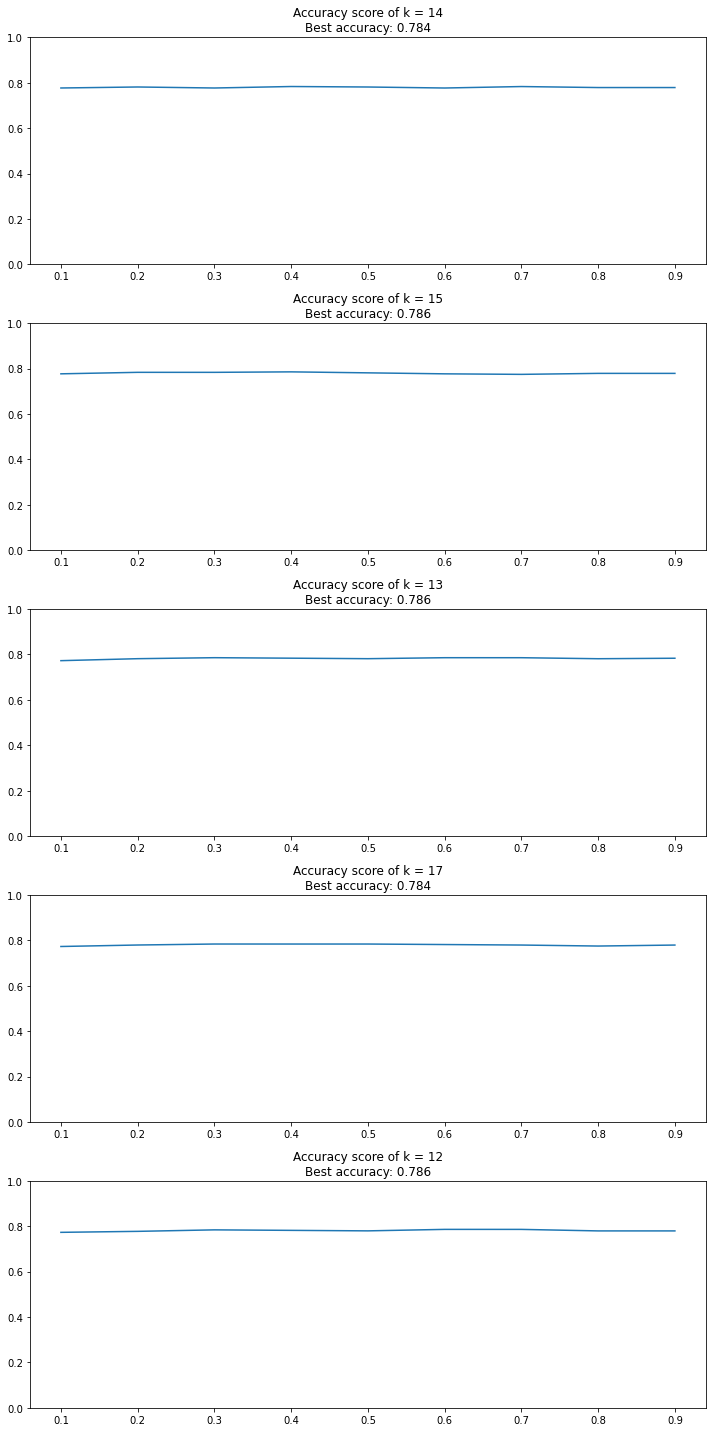

In [25]:
x_space = np.linspace(0.1, 0.9, 9)
n = len(list(bestDf.columns))

plt.subplots(figsize=(10, 20))

for i, col_name in enumerate(bestDf):
    plt.subplot(n, 1, i+1)
    plt.plot(x_space, bestDf.loc[:, col_name].values)
    plt.title('Accuracy score of {}\nBest accuracy: {:.3f}'.format(col_name, np.max(bestDf.loc[:, col_name].values)))
    plt.ylim([0.0, 1.0])
    plt.tight_layout()

plt.show()

Show perpelxity for each kBest

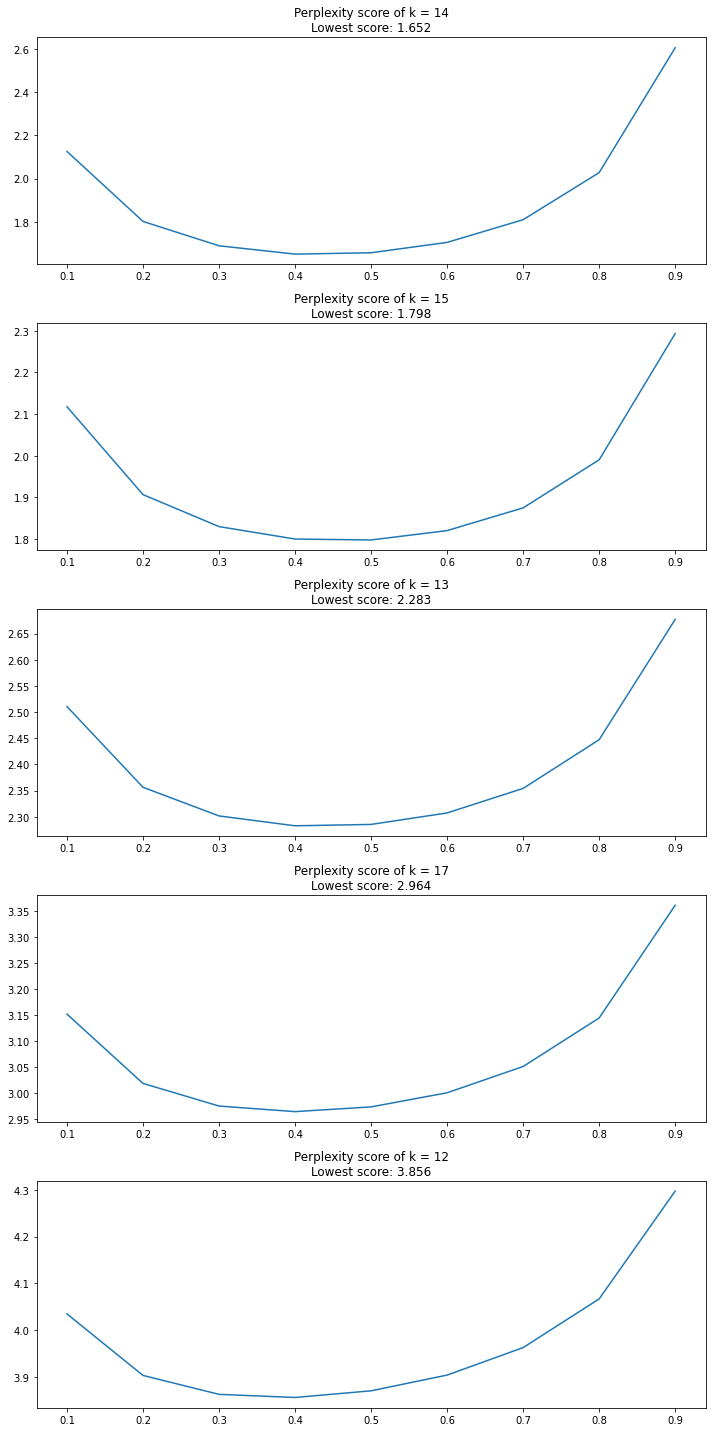

In [26]:
x_space = np.linspace(0.1, 0.9, 9)
n = len(list(bestDf.columns))

plt.subplots(figsize=(10, 20))

for i, col_name in enumerate(bestDf):
    plt.subplot(n, 1, i+1)
    plt.plot(x_space, perp[:, i])
    plt.title('Perplexity score of {}\nLowest score: {:.3f}'.format(col_name, np.min(perp[:, i])))
    plt.tight_layout()

plt.show()

# ROC curves

Calculate values

In [27]:
def get_xy(df):
    if ('class4' in df.columns.values):
        df = df.drop('class4', axis=1)
    X = df.drop('class2', axis=1).values
    y = data['class2'].ravel()
    return [X, y]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i, col_name in enumerate(bestDf):
    num_of_k = col_name[3:].strip()
    k_best_columns = data_to_use.columns.values[k_best[num_of_k].get_support(indices=True)]
    features = data_to_use[k_best_columns].values
    predictable = data_to_use['class2'].ravel()
    X_train, X_test, y_train, y_test = train_test_split(features, predictable, test_size=0.3, random_state=0)
        
    y_pred_prob = gnb.fit(X_train, y_train).predict_proba(X_test)[:, 1]

    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob)
    roc_auc[i] = auc(fpr[i], tpr[i]) 

Confusion matrices for best kBest features

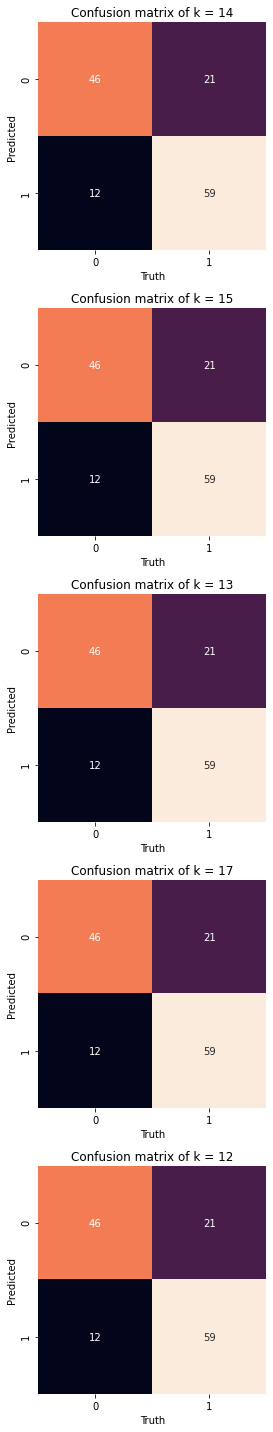

In [28]:
n = len(list(bestDf.columns))

plt.subplots(figsize=(20, 20))

for i, value in enumerate(bestDf):
    num_of_k = col_name[3:].strip()
    k_best_columns = data_to_use.columns.values[k_best[num_of_k].get_support(indices=True)]
    features = data_to_use[k_best_columns].values
    predictable = data_to_use['class2'].ravel()
    X_train, X_test, y_train, y_test = train_test_split(features, predictable, test_size=0.3, random_state=0)
        
    y_pred_val = gnb.fit(X_train, y_train).predict(X_test)

    plt.subplot(n, 1, i+1)
    # Plot Confusion Matrix
    mat = confusion_matrix(y_pred_val, y_test)
    names = np.unique(y_pred_val)
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=names, yticklabels=names)
    plt.xlabel('Truth')
    plt.ylabel('Predicted')
    plt.title('Confusion matrix of {}'.format(value))
    plt.tight_layout()

plt.show()

ROC cureves for kBest features

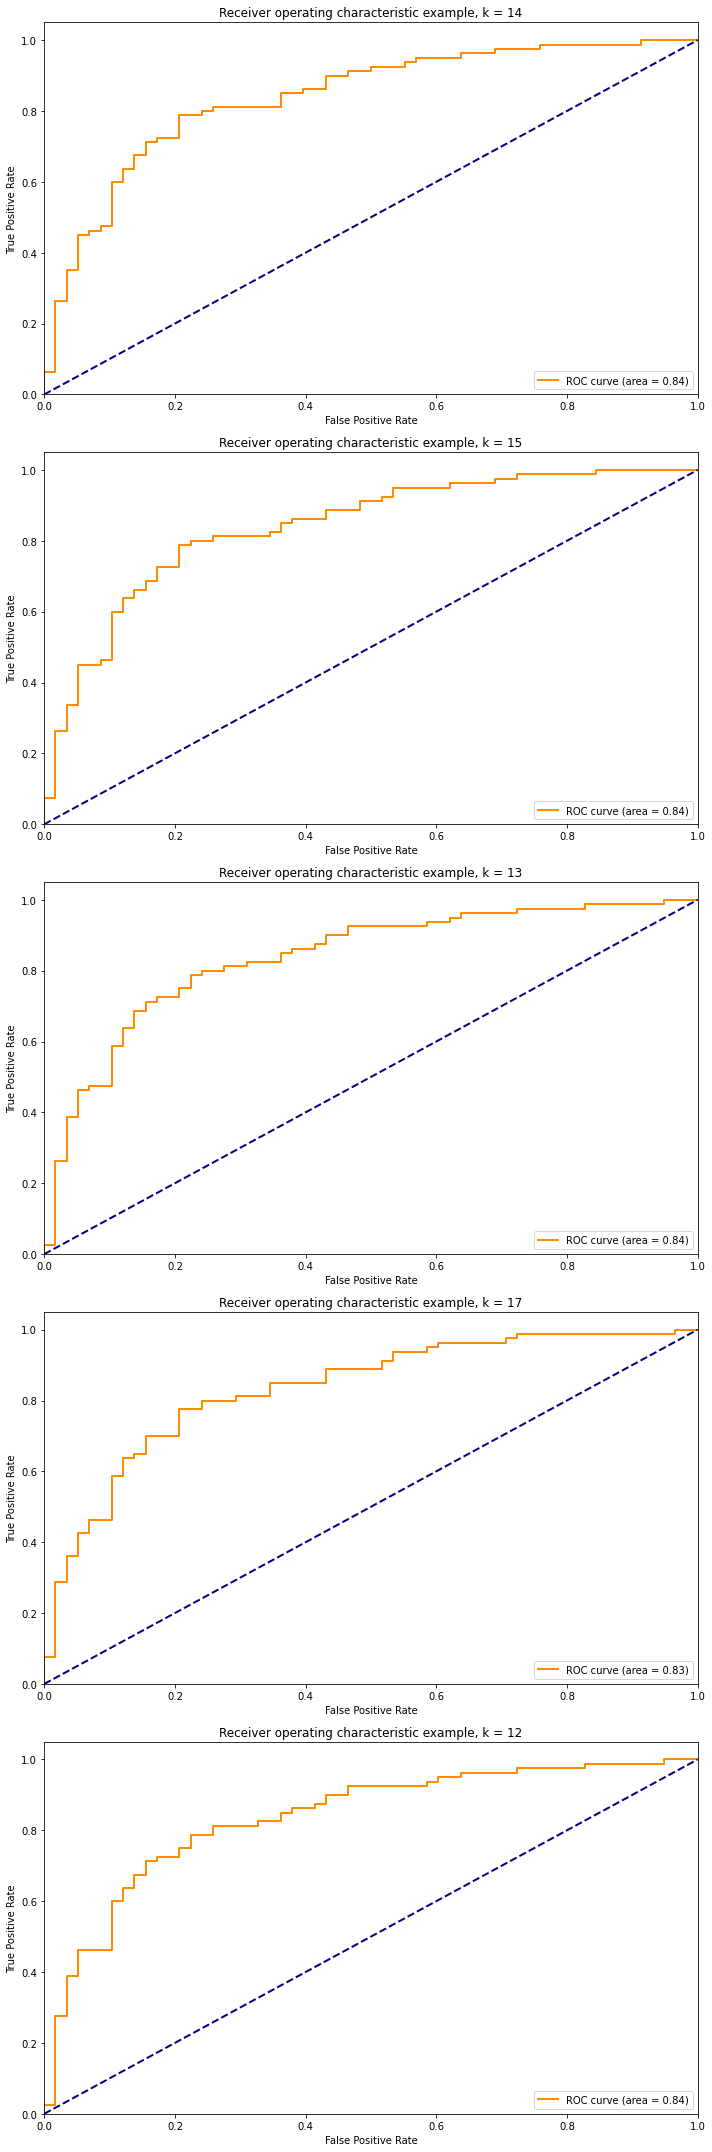

In [29]:
n = len(list(bestDf.columns))

plt.subplots(figsize=(10, 30))

for i, col_name in enumerate(bestDf):
    plt.subplot(n, 1, i+1)
    lw = 2
    plt.plot(
        fpr[i],
        tpr[i],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[i],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example, {}".format(col_name))
    plt.legend(loc="lower right")
    plt.tight_layout()

plt.show()

# Summary

The best score seems to be when the select kBest = 14. These features are 'CO2504.mean', 'Glob.mean', 'H2O672.mean', 'NET.mean', 'NOx672.mean', 'O3672.mean', 'PAR.mean', 'PTG.mean', 'RGlob.mean', 'RHIRGA672.mean', 'RPAR.mean', 'SWS.mean', 'UV_A.mean', 'CS.mean'.

For this model:

Accuracy = $0.784$

Perplexity = $1.652$

Area under the ROC curve = $0.84$

Now concidering all of the above result this model is probably not best to choose for this classification task since the perplexity and accuracy could be better.